In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quandl
import functools
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [165]:
@functools.lru_cache(maxsize=16)
def fetch_quandl(my_securities,sdate,edate):
    qdata = quandl.get(list(my_securities), returns="pandas",authtoken=cp_keys['quandl'],start_date=sdate, end_date=edate)
    return qdata


In [166]:
def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.iteritems():
            if tenor>0.001:
                times = np.arange(tenor-0.25, 0, step=-0.25)[::-1]
                coupon_quarterly = 0.25*spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values) # Linear interpolation
                preceding_coupons_val = (coupon_quarterly*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_quarterly))/tenor
    return zcb_rates

def bond_price(zcb, coupon_rate, tenor):
    zcb.index = zcb.index.astype('int64')
    times = np.arange(tenor, 0, step=-0.5)[::-1]
    if times.shape[0]==0:
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        p = np.exp(-tenor*r[-1]) + 0.5 * coupon_rate * np.exp(-r*times).sum()
    return p


In [167]:
sdate,edate="2000-01-01","2023-02-07"

##### Obtain 1M (0.08Y) rates for UK overnight index swaps (OIS) along with spot rates for the dollar versus pound

In [168]:
fx_gbp=fetch_quandl(("CUR/GBP",),sdate,edate)

ois1=fetch_quandl(("YC/GBR_ISSC",),sdate,edate)
ois2 = fetch_quandl(("YC/GBR_ISSS",),sdate,edate)
ois1.rename(columns={col: col.replace("GBR_ISSC", "GBR_ISSS") for col in ois1.columns}, inplace=True)
ois = pd.concat([ois1, ois2], ignore_index=False)
ois = ois.drop_duplicates(keep='last')


In [169]:
def fetch_yc_fx(country):
    country_codes = {
        'Thailand': ('THB', 'THA', [1/12, 3/12, 6/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15]),
        'Vietnam': ('VND', 'VNM', [1, 2, 3, 5, 7, 10, 15]),
        'Pakistan': ('PKR', 'PAK', [3/12, 6/12, 1, 3, 5, 10]),
        'Philippines': ('PHP', 'PHL', [1/12, 3/12, 6/12, 1, 2, 3, 4, 5, 7, 10, 20, 25])
    }

    if country not in country_codes:
        raise ValueError("country not in our list, available countries are Thailand, Vietnam, Pakistan, Philippines")

    cur_code, yc_code, columns = country_codes[country]
    fx = fetch_quandl(("CUR/{}".format(cur_code),), sdate, edate)
    lend = fetch_quandl(("YC/{}".format(yc_code),), sdate, edate) / 100
    lend = lend.interpolate(axis=0, method='index')
    lend.columns = columns

    return fx, lend


In [170]:
def carry_trade(lend,ois,fx):
    
    lend_zcb = compute_zcb_curve(lend.T).T

    full_data_temp = pd.concat([lend[5],fx,ois['YC/GBR_ISSS - 0.08Y']], axis=1)
    full_data_temp.rename(columns={5: '5 year swap'}, inplace=True)

    full_data = pd.concat([full_data_temp, lend_zcb], axis=1)

    full_data.index = pd.to_datetime(full_data.index)

    start_date = pd.to_datetime('2014-12-01')
    timestamp = pd.Timestamp(lend.index[-1])
    end_date = pd.to_datetime(timestamp.strftime('%Y-%m-%d'))

    #data is truncated for range where we have 5 year yield, ois rate, fx rate, and swap curve
    full_data = full_data[(full_data.index >= start_date) & (full_data.index <= end_date)]
    full_data['price'] = np.nan

    for i in range(len(full_data)):
        #note: zero coupon bonds are being priced without the coupon yield
        #I add accrued interest manually in the pnl calculation
        result = bond_price(full_data.iloc[i,3:-1], 0, 5-1/52)
        full_data.at[full_data.index[i], 'price'] = result

    full_data.fillna(method='ffill', inplace=True)

    #keep data only for Wednedays
    #we will enter and exit the trade weekly, on Wednesday
    full_data_wed = full_data[full_data.index.weekday == 2].copy()
    full_data_wed

    full_data_wed['profit'] = np.nan

    for i in range(1,len(full_data_wed)):
        wallet = 0
        units = 10e6*full_data_wed.iloc[i-1, 1]/full_data_wed.iloc[i-1]['price']
        net_cashflow = (units * (full_data_wed.iloc[i]['5 year swap']-0.8*(full_data_wed.iloc[i]['YC/GBR_ISSS - 0.08Y']+0.5)/100))/52
        wallet += net_cashflow/full_data_wed.iloc[i, 1]
        wallet += (units*full_data_wed.iloc[i]['price'])/full_data_wed.iloc[i, 1]
        
        full_data_gbp = full_data_wed.merge(fx_gbp, how='inner', left_index=True, right_index=True)
        
        #take pnl from GBP exposure (we are borrowing in GBP and marking to market in USD)
        wallet += 10e6*(full_data_gbp['CUR/GBP - RATE'].iloc[i] - full_data_gbp['CUR/GBP - RATE'].iloc[i-1])

        if (full_data_wed.iloc[i-1,0]-full_data_wed.iloc[i-1,2]/100) < 0.5/100:
            full_data_wed.at[full_data_wed.index[i], 'profit'] = 0
        else:
            full_data_wed.at[full_data_wed.index[i], 'profit'] = wallet - 10e6
            

    full_data_wed['cum_profit'] = full_data_wed['profit'].cumsum()
    
    return full_data_wed


In [186]:
def graph_results(full_data_wed, country):
    
    fx_correlation = round((1/full_data_wed.iloc[:,1]).corr(full_data_wed.iloc[:,-1]),2)
    returns = full_data_wed['profit']/2e6

    fig = plt.figure(figsize=(18, 7))
    plt.plot(full_data_wed['cum_profit'])
    plt.title(country + " Carry Trade Cumulative Profit over Time", fontsize=20)
    plt.xlabel("Date", fontsize=15)
    plt.ylabel("Cumulative Profit (in USD)", fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=13)
    plt.show()

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    ax[0].plot(1/full_data_wed.iloc[:, 1])
    ax[0].set_xlabel('Index', fontsize=15)
    ax[0].set_ylabel('Forex rate', fontsize=15)
    ax[0].tick_params(axis='both', which='major', labelsize=13)
    ax[0].set_title('Forex rate over time')

    ax[1].plot(100*full_data_wed['5 year swap'], label='5-year Yield')
    ax[1].plot(full_data_wed['YC/GBR_ISSS - 0.08Y']+0.5, label='OIS + 50bps')
    ax[1].set_xlabel('Date', fontsize=15)
    ax[1].set_ylabel('Yield/Swap Rate (in %)', fontsize=15)
    ax[1].tick_params(axis='both', which='major', labelsize=13)
    ax[1].set_title('5-year Swap Rate and OIS')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    ax[0].hist(100*full_data_wed['profit']/2e6, bins=50)
    ax[0].set_xlabel('Weekly Return (%)', fontsize=15)
    ax[0].set_ylabel('Frequency', fontsize=15)
    ax[0].tick_params(axis='both', which='major', labelsize=13)
    ax[0].set_title('Distribution of Returns')

    ax[1].axis('off')
    data = [[round(returns.mean(),2)], [round(returns.median(),2)], [round(returns.std(),2)], [round(returns.skew(),2)], [round(returns.kurtosis(),2)],[fx_correlation]]
    column_labels = ['Weekly Returns']
    row_labels = ['Mean', 'Median', 'Volatility', 'Skewness', 'Kurtosis', 'Correlation with FX']
    table = ax[1].table(cellText=data,
    colLabels=column_labels,
    rowLabels=row_labels,
    loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1, 1.5)

    ax[1].set_title('Selected Statistics')

    plt.tight_layout()
    plt.show()
    

# Rationale of the carry trade

Carry trades involve borrowing in a currency with low interest rates and investing in a currency with higher interest rates, in the hopes of earning a profit from the interest rate differential. This strategy can be effective in emerging markets, where high yield government bonds may present an opportunity to profit from their spread relative to domestic (developed market) government bonds.

For example, if an investor borrows Japanese yen (which has historically a low interest rate and been a popular source for carry trades) and invests in high yield government bonds in an emerging market like Pakistan (which has very high interest rates), they could earn a substantial profit. This is because the interest rate differential would provide a steady stream of income.

Naturally, carry trades can be risky and are influenced by many factors, including changes in exchange rates, and the actual bond prices (driven by yield and of course solvency). However, they may offer attractive returns and diversification benefits to investors. It's also important to consider the underlying economic and political conditions of the countries involved, as well as the stability of their currencies, before investing in carry trades. For example, some policies can move markets in "irrational" directions. For example, a change in monetary regime from pegged to floating, or a change from yield control to letting the yield fluctuate.

# Pakistan Carry Trade

In [187]:
country = 'Pakistan'
# Collect the data
fx,lend = fetch_yc_fx(country)

# Execute carry_trade
full_data_wed = carry_trade(lend,ois,fx)

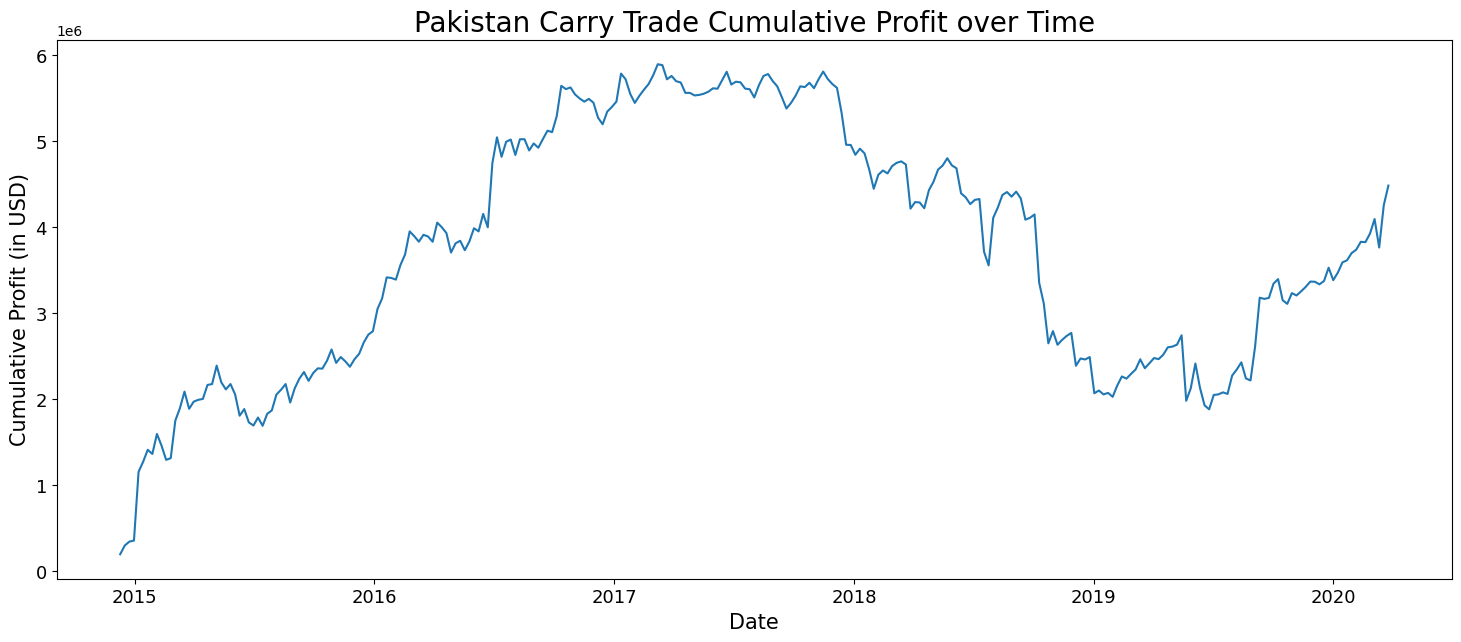

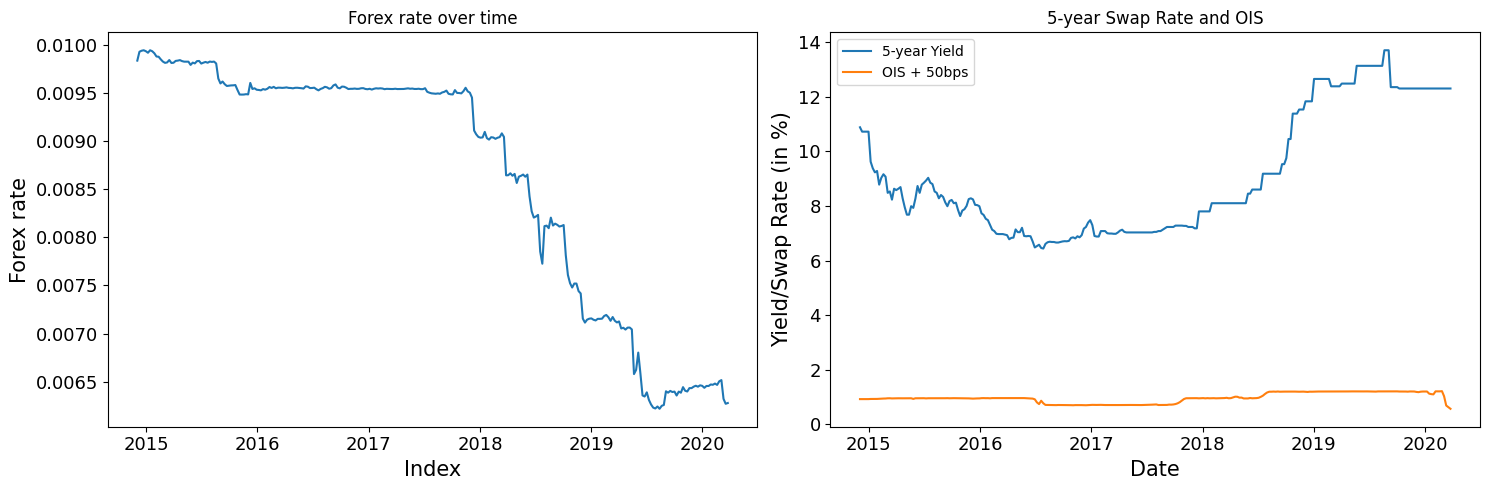

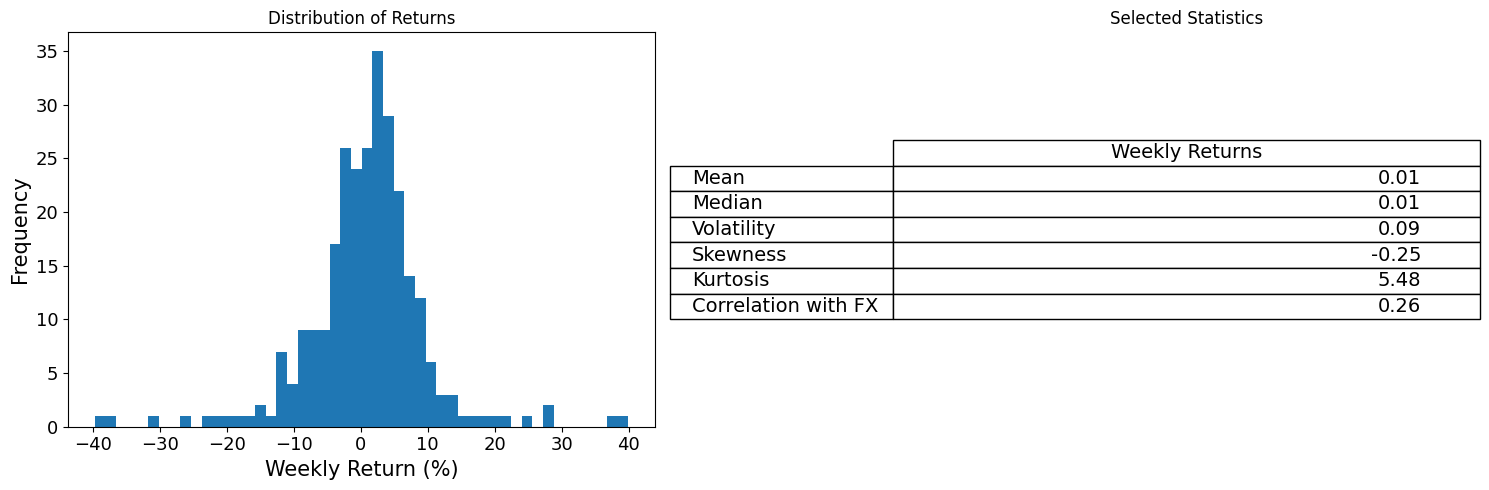

In [188]:
# Graph the cumulative return if we invest 10M USD notional every week on Wednesday
# Note that we are only entering trades when the spread between 5-year swap and OIS+50bps is positive
graph_results(full_data_wed, country)

### Insights

1. The USDPKR rate is increasing. This means that the Pakistani Rupee (lending currency) is depreciating. Particularly in 2018 where a large trade deficit, high inflation, and a shortage of foreign currency reserves led to a currency crisis in Pakistan. Over this period, our trade is performining extremely poorly because we have direct exposure to PKR.
2. The 5 year swap rate in Pakistan is very high yielding. It ranges from 6 to almost 14%. This is where we are getting returns on the carry since this rate is much higher than our funding rate (OIS + 50bps).
3. Over our investment horizon, the strategy is positive, ending with a 216% levered return. This means that the bond effect (change change and yield carry) is more than compensating for the forex loss.

# Vietnam Carry Trade

In [189]:
country = 'Vietnam'
# Collect the data
fx,lend = fetch_yc_fx(country)

# Execute carry_trade
full_data_wed = carry_trade(lend,ois,fx)

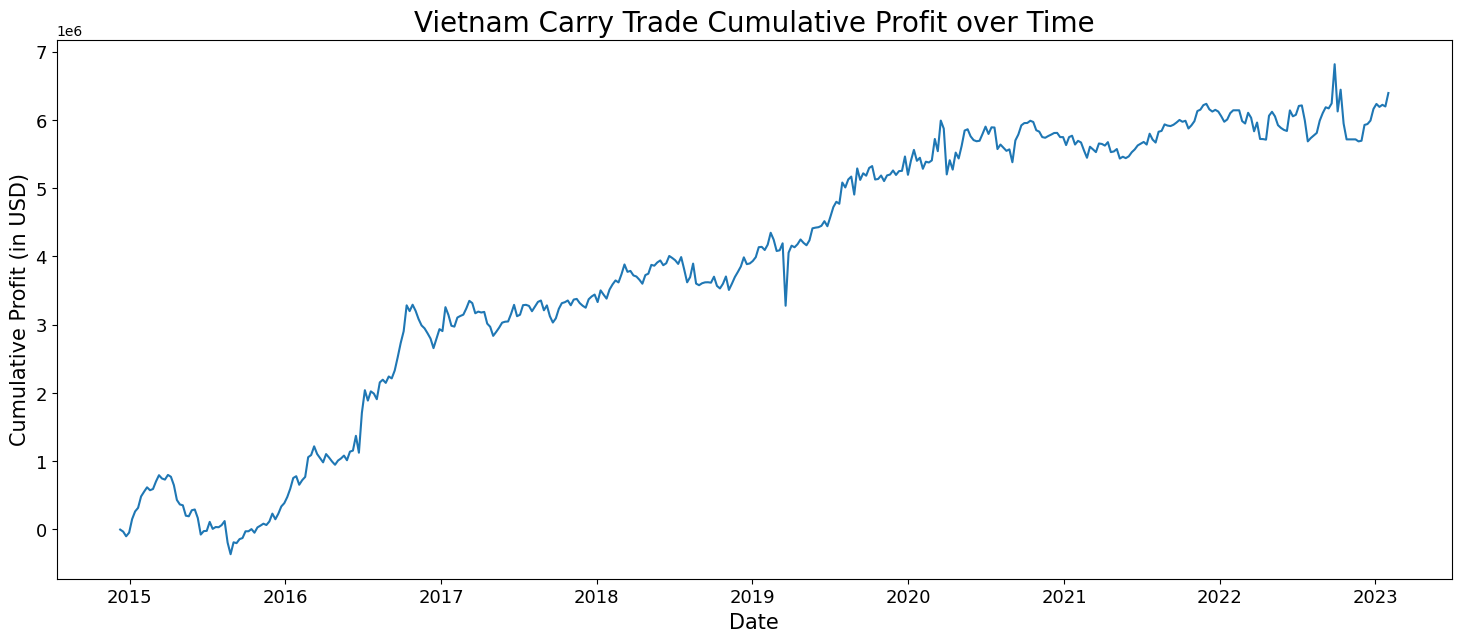

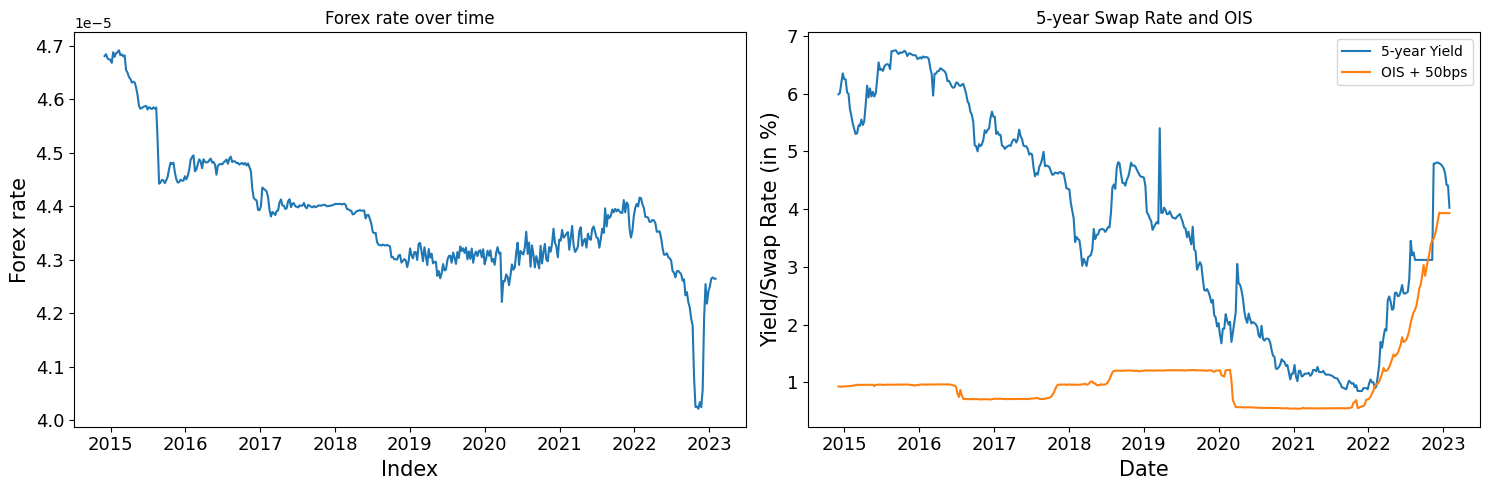

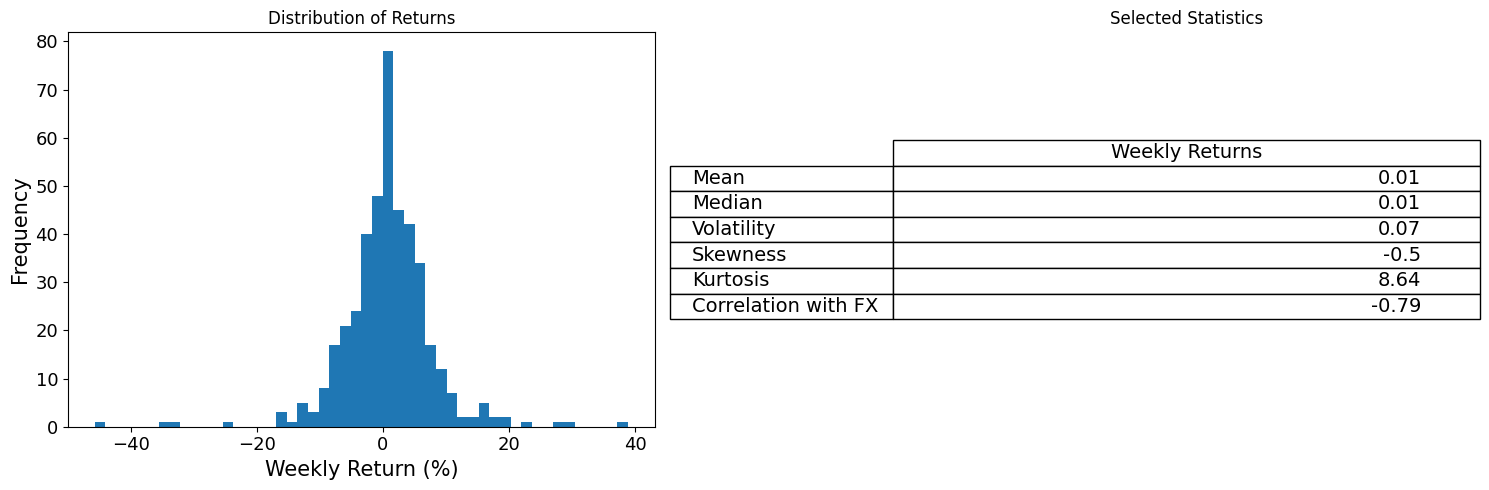

In [190]:
# Graph the cumulative return if we invest 10M USD notional every week on Wednesday
# Note that we are only entering trades when the spread between 5-year swap and OIS+50bps is positive
graph_results(full_data_wed, country)

### Insights

1. The USDVND rate is generally increasing. This means that the Vietnamese Dong (lending currency) is depreciating. Over this period, our trade is performining extremely poorly because we have direct exposure to VND.
2. The 5 year swap rate in Vietnam is generally high yielding. It ranges from 1 to almost 7%. This is where we are getting returns on the carry since this rate is higher than the funding rate (OIS + 50bps). Note that this spread is smaller than in Pakistan. in fact, in some periods of 2022, the spread closes completely and we stop trading. Since we are holding the bonds, we are getting actual price appreciation since the relationship between yields and prices is inverse. This is unique to this trade and is a contributor to why it's best performing.
3. Over our investment horizon, the strategy is positive, ending with a 309% levered return. This means that the bond effect (change change and yield carry) is more than compensating for the forex loss. Interestingly, after 2020, the spread is small, so we become very sensitive to forex changes. This explains why the return from 2020 to 2023 is much lower.

# Philippines Carry Trade

In [191]:
country = 'Philippines'
# Collect the data
fx,lend = fetch_yc_fx(country)

# Execute carry_trade
full_data_wed = carry_trade(lend,ois,fx)

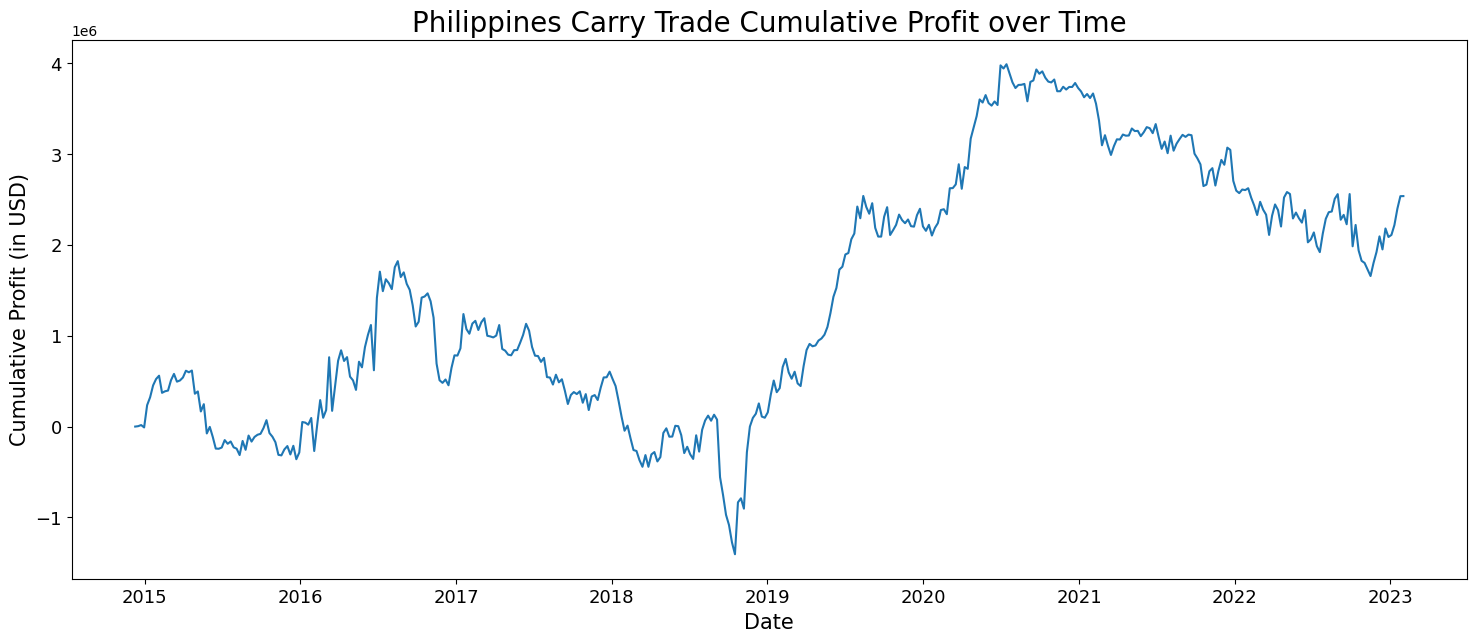

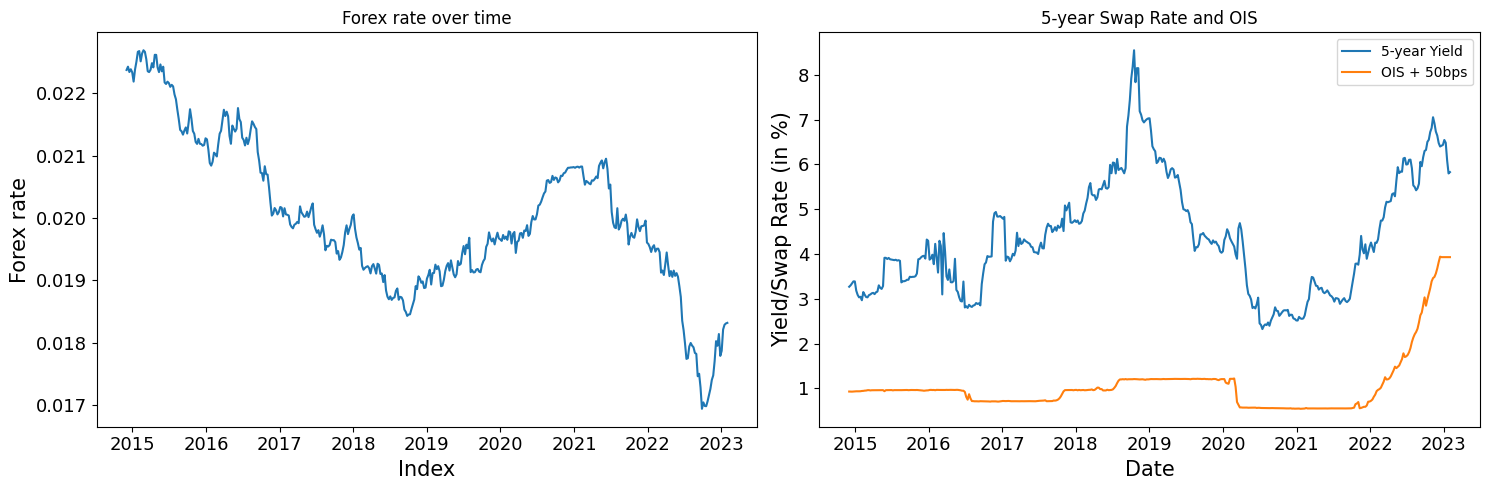

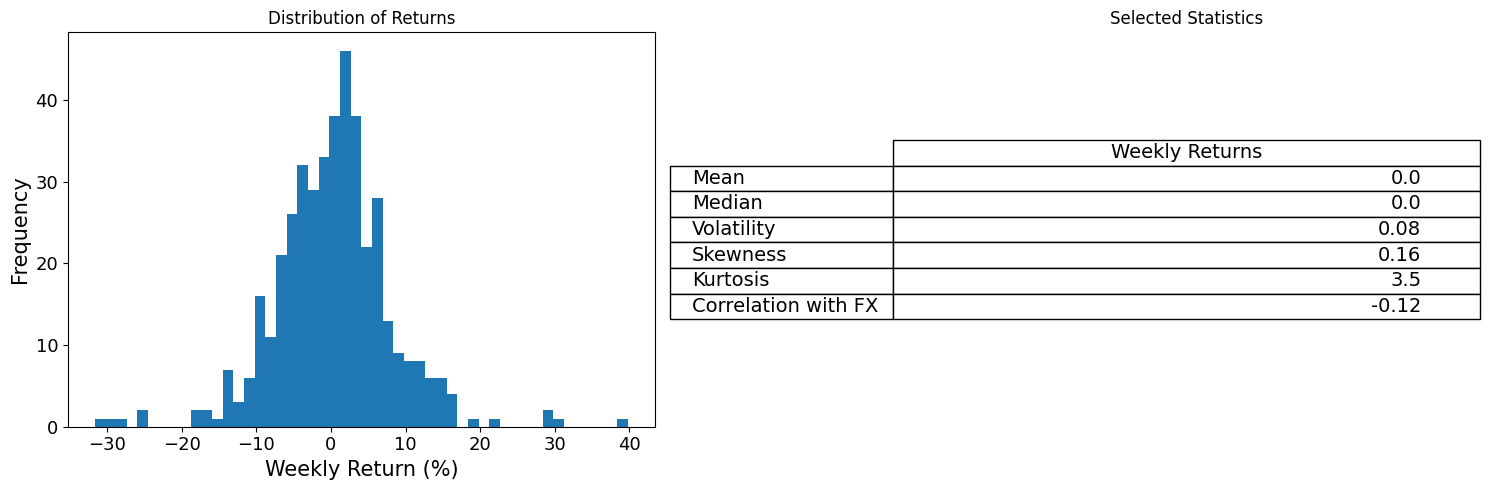

In [192]:
# Graph the cumulative return if we invest 10M USD notional every week on Wednesday
# Note that we are only entering trades when the spread between 5-year swap and OIS+50bps is positive
graph_results(full_data_wed, country)

### Insights

1. The USDPHP rate is generally increasing. This means that the Philippine Peso (lending currency) is depreciating. Over this period, our trade is performining extremely poorly because we have direct exposure to PHP.
2. The 5 year swap rate in the Philippines is generally high yielding. It ranges from 2 to 9%. This spread stays positive and large over the entire period.
3. Over our investment horizon, the strategy has a 116% levered return, ending with a 0% return. This means that the bond effect (change change and yield carry) is only partially offset by the forex loss. Interestingly, after 2020, the spread is small, so we become very sensitive to forex changes. This explains why the return from 2020 to 2023 is 0%. It seems our return is entirely driven by the 2019-2021 period where bond prices increased and the fx rate improved.

# Thailand Carry Trade

In [193]:
country = 'Thailand'
# Collect the data
fx,lend = fetch_yc_fx(country)

# Execute carry_trade
full_data_wed = carry_trade(lend,ois,fx)

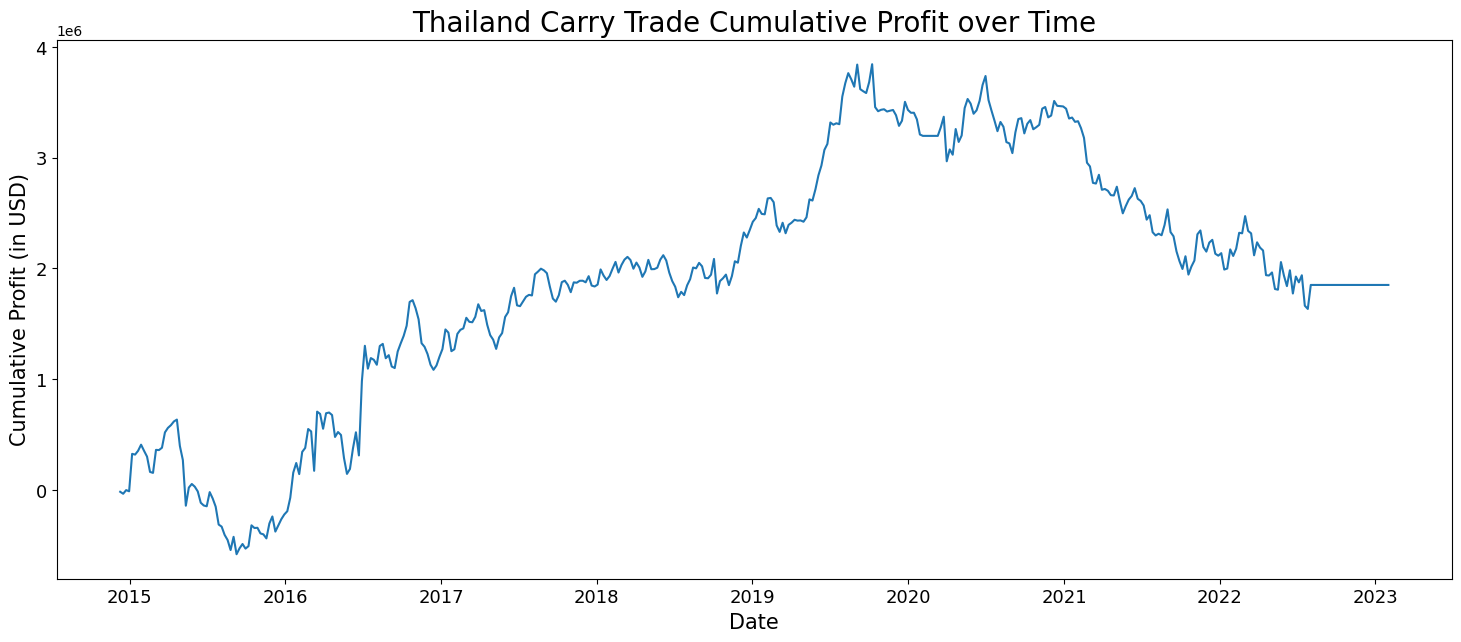

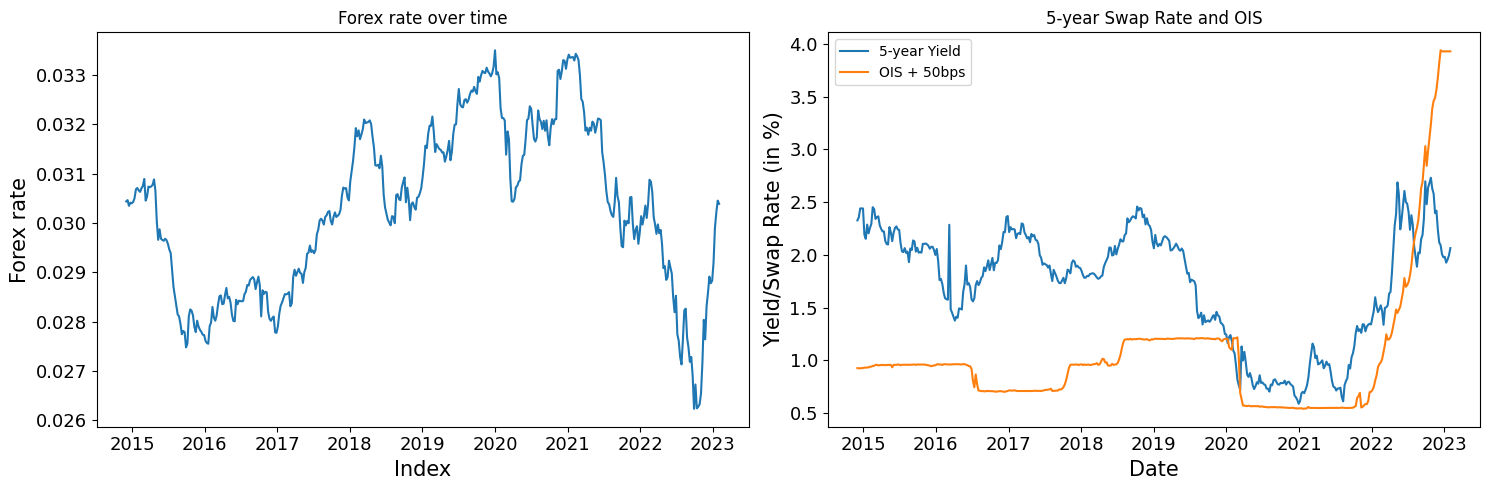

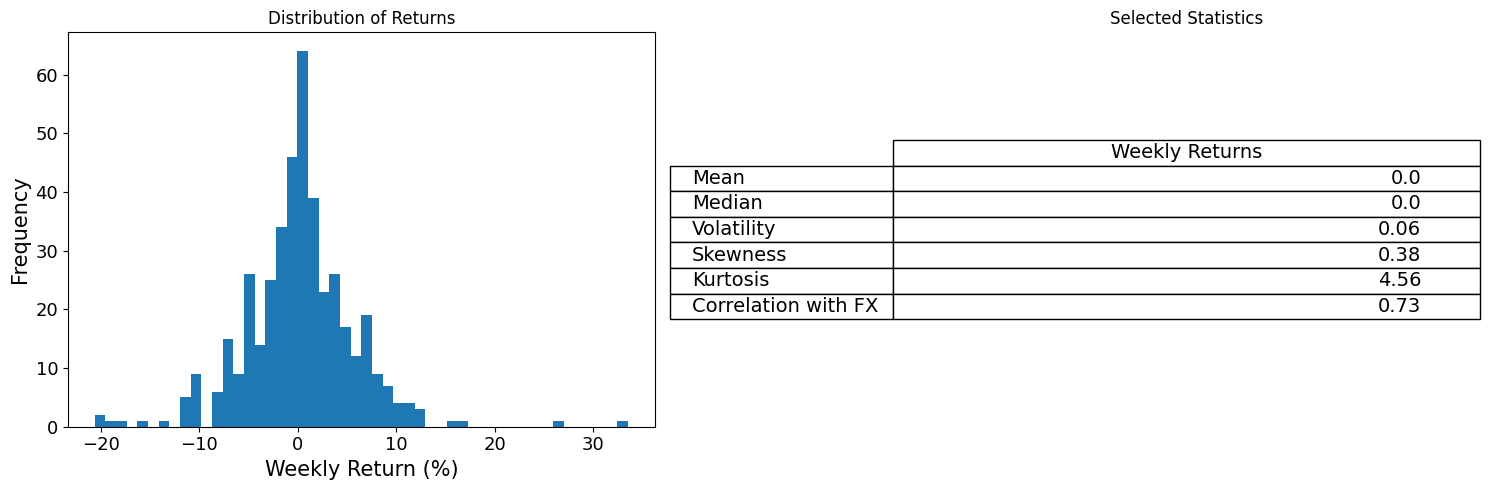

In [194]:
# Graph the cumulative return if we invest 10M USD notional every week on Wednesday
# Note that we are only entering trades when the spread between 5-year swap and OIS+50bps is positive
graph_results(full_data_wed, country)

### Insights

1. The USDTHB rate is generally increasing. This means that the Thai Baht (lending currency) is depreciating. Over this period, our trade is performining more poorly direct exposure to THB.
2. The 5 year swap rate in Thailand is not high yielding like the others. It ranges from 0.75 to 2.75%. This means that the spread between 5y swap and OIS+50bps closes around 2020 and becomes small thereafter. Since we are not trading when the spread closes, the returns  beceome flat.
3. Over our investment horizon, the strategy has a 85% levered return. This means that the bond effect (change change and yield carry) is partially offset by the forex loss. Again, after 2020, the spread is small, so we become very sensitive to forex changes. This leads us to ride the forex rate down in mid 2022, but we sit on the sidelines and miss the great appreciation in late 2022.

# Analysis:

1. Emerging markets forex depreciation. The main reason for forex depreciation for our countries of interest is global financial tightening led by the fed. Although the Fed began tightening in March 2022, it began being priced in as of January 2022. The result was that investors are attracted to high yields in US bonds, so they move capital to US, strenghtening the dollar (we are long foreign currencies, so we take forex loss in all strategies). Indeed, there is also a reduction in flow of innvestment to EM because of fight to safety

2. Distribution of returns. The returns are positively skewed for Thailand and Philippines, but negative for Pakistan and Vietnam. Perhaps more interestingly, there is excess kurtosis in all strategies. This means that the returns are tight around the mean. This is likely due to the fact that forex and effect and bond effect have negative correlation. We can see that there are many many small returns or losses, with a few instances of extreme returns.

3. Unacceptable risk. All stragis see instances of 1 week losses above 20%, and up to -45% for Pakistan carry. This is well beyond any risk management that would be considered acceptable. Furthermore, this exercise shows how stark the forex risk is in our carry trade set up. We can also see that the correlation between fx rates (foreign to USD) and carry trade returns become very highly correlated when the returns start being negative. This is similar to what we see in equities when uncorrelated assets become very correlated in a crash. This is likely a big hidden risk in our strategy.


# Out of sample testing

In [195]:
start_date = pd.to_datetime('2014-12-01')
end_date = pd.to_datetime('2020-01-01')

in_sample = {}
out_of_sample = {}
cum_return = {}
    
for i in ['Thailand','Vietnam','Philippines','Pakistan']:
    country = i

    fx,lend = fetch_yc_fx(country)
    full_data_wed = carry_trade(lend,ois,fx)
    
    in_sample_data = full_data_wed[(full_data_wed.index >= start_date) & (full_data_wed.index <= end_date)]
    out_of_sample_data = full_data_wed[(full_data_wed.index >= end_date)]
    
    cum_return[country] = full_data_wed.iloc[-1,-1]/2e6
    in_sample[country] = in_sample_data.iloc[-1,-1]/2e6
    out_of_sample[country] = (out_of_sample_data.iloc[-1,-1]-out_of_sample_data.iloc[0,-1])/2e6


In [196]:
in_sample

{'Thailand': 1.7157576521330653,
 'Vietnam': 2.5977370816140093,
 'Philippines': 1.1010747368945208,
 'Pakistan': 1.693134828428587}

In [197]:
out_of_sample

{'Thailand': -0.7902591729868157,
 'Vietnam': 0.5993964919593967,
 'Philippines': 0.16700914387551602,
 'Pakistan': 0.5497573025355004}

We can see some positive results from in-sample testing to find the best currency to which we should apply a carry-trading strategy. As we can see in the in-sample testing from 2014-12-01 until 2020-01-01, we find that the Vietnam carry trade is greatly outperforming others over the sample period.

Knowing this, if we trade only on the Vietnamese currency out of sample, that is from 2020-01-02 until present, we get positive returns. Out of sample, Vietnam is returning +60.0%. This is better than Thailand at -81.1%, Philippines at +11.9%, Pakistan at +54.5% (the figure for Pakistan is not reliable as data ends at 2020 in April).

As a conclusion, we are likely just getting lucky in this sample selection. We see tremendous variability of cummulative returns and other factors that lead us to never consider this trade as it would never fit our risk parameters. Furthermore, our dataset contains too many historical anomalies to be reliable as a trading strategy. The out-of-sample data contain COVID, where monetary loosening and market uncertainty moved all bond and fx markets. It also contains the monetary tightening that started in 2022, which again affects all bonds and fx markets.

For further exploration, this carry trade might work if we diversify across eenough currencies to avoid local currency or bond marktet disruptions in the short term. Since over our full sample, all strategies have positive returns, this could be viable.

# Potential diversification benefits?

In [198]:
df_pnl = pd.DataFrame()
for i in ['Thailand','Vietnam','Philippines','Pakistan']:
    
    country = i
    fx,lend = fetch_yc_fx(country)
    full_data_wed = carry_trade(lend,ois,fx)
    df_pnl[country] = full_data_wed['profit'].copy()

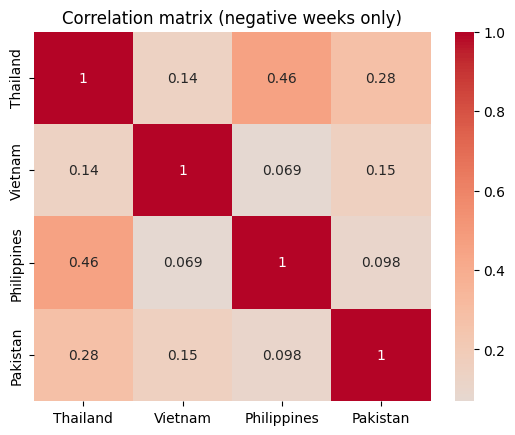

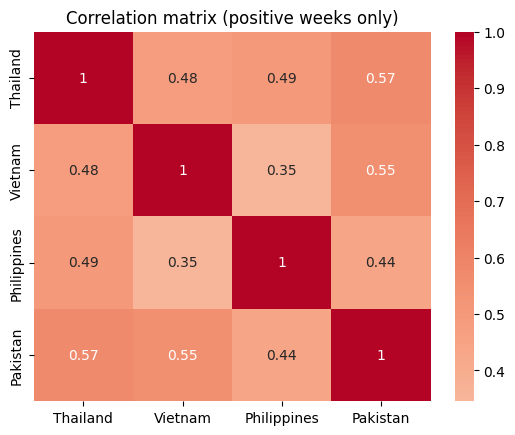

In [199]:
df_pnl_trim = df_pnl.dropna().copy()

df_negative = df_pnl_trim[df_pnl_trim < 0]
df_positive = df_pnl_trim[df_pnl_trim > 0]

corr_matrix_negative = df_negative.corr()
corr_matrix_positive = df_positive.corr()

sns.heatmap(corr_matrix_negative, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation matrix (negative weeks only)')
plt.show()

sns.heatmap(corr_matrix_positive, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation matrix (positive weeks only)')
plt.show()

Since the returns of different countries are less correlated during negative market conditions, it suggests that a carry trade portfolio may be less exposed to systematic risk, as the returns of the different countries would not all be moving in the same direction. In other words, if one country is performing poorly, it is less likely that all the other countries in the portfolio will also be performing poorly. This could lead to a more diversified portfolio and potentially lower risk.

When one country is performing poorly during a market downturn, it becomes likely that other countries in the portfolio will not follow the trend and instead perform well. As a result, a carry trade portfolio may be less exposed to systematic risk than trading on one currency alone and the idiosyncratic risk could be diversified away.

In essence, a diversified carry trade portfolio can help to reduce the risk of losses by spreading the investment across different countries and currencies. This is why diversification is a key component of risk management in investing. By investing in a range of countries, an investor can potentially reduce the risk of losing money due to a single country's economic performance. This is in contrast with equity investing where we typically experience high correlation between sectors and traditional asset classes in general during market downturns.

In conclusion, it would be interesting to examine the possibilty of investing in a broader set of high yielding markets such as China and Brazil, and the possibility of financing in different markets such as Japan or Euro, and studying the carry trade returns in aggregate.